In [26]:
import datasets
import pandas as pd
import os
from tqdm import tqdm 

In [27]:
meta_dir = "/data/meta"
xeno_canto = datasets.load_from_disk(os.path.join(meta_dir, "xeno_canto")).with_format("pandas")
bergman = pd.read_csv(os.path.join(meta_dir, "bergman_en.csv"))

In [47]:
from random import sample
xc_labels = sample(xeno_canto.with_format(None)["simple_label"], 15)
bergman_labels = sample(bergman.label.to_list(), 15)
print(xc_labels)
print()
print(bergman_labels)

['Rallus aquaticus; morning; week 27; 2013; Polska; 26.0 seconds; 5 of 5; call; adult', 'Psittacus erithacus; afternoon; week 11; 2019; Cameroun; 75.4 seconds; 4 of 5; song', 'Athene noctua; evening; week 10; 2019; Portugal; 18.2 seconds; 4 of 5; song; Carduelis carduelis; Turdus merula', 'Periparus ater; morning; week 21; 2015; 日本; 15.9 seconds; 5 of 5; song', 'Caprimulgus europaeus; night; week 22; 2015; Sverige; 6.7 seconds; 3 of 5; call', 'Muscicapa griseisticta; afternoon; week 02; 2019; 日本; 80.4 seconds; 3 of 5; song; Sittiparus varius; Hypsipetes amaurotis', 'Unknown; evening; week 37; 2016; Deutschland; 276.0 seconds; 0 of 5; song; call; Lophophanes cristatus; Troglodytes troglodytes', 'Cyanistes cyanus; morning; week 22; 2018; ЦЕНТРОБАНК РФ ВСЕХ НAЕБАЛ; 2.8 seconds; 4 of 5; call', 'Phylloscopus trochilus; morning; week 21; 2017; United Kingdom; 141.2 seconds; 2 of 5; song; Troglodytes troglodytes; Turdus merula; Turdus philomelos; Columba palumbus; Emberiza citrinella; Fringil

In [49]:
xc_labels[-8]

'Cyanistes cyanus; morning; week 22; 2018; ЦЕНТРОБАНК РФ ВСЕХ НAЕБАЛ; 2.8 seconds; 4 of 5; call'

In [3]:
sci_names = pd.concat([xeno_canto["sci_name"], bergman["name_sci"]], ignore_index=True)
sci_names.fillna("Unknown", inplace=True)
sci_name_counts = sci_names.value_counts()

In [4]:
with open("/data/BirdNET-Analyzer/labels/V2.4/BirdNET_GLOBAL_6K_V2.4_Labels_de.txt") as f:
    birdnet_sci_names = f.read().split("\n")
    birdnet_sci_names = [name[:name.find("_")] for name in birdnet_sci_names if name != ""]
    birdnet_sci_names = set(birdnet_sci_names)

In [25]:
is_contained = sci_names.map(lambda x: x in birdnet_sci_names)
print(is_contained.mean(), "% of samples")

is_contained = pd.Series(sci_names.unique()).map(lambda x: x in birdnet_sci_names)
print(is_contained.mean(), "% of classes")

print("reduced")
reduced_xeno_canto = xeno_canto.filter(lambda x: x.get("duration") <= 32)["sci_name"]
reduced = pd.concat([reduced_xeno_canto, bergman["name_sci"]], ignore_index=True)
reduced.fillna("Unknown", inplace=True)

is_contained = reduced.map(lambda x: x in birdnet_sci_names)
print(is_contained.mean(), "% of samples")

is_contained = pd.Series(reduced.unique()).map(lambda x: x in birdnet_sci_names)
print(is_contained.mean(), "% of classes")

0.8807196505981254 % of samples
0.6094411942707283 % of classes
reduced
0.0 % of samples
0.0 % of classes


In [30]:
sci_name_counts.std()

268.69754725893927

<Axes: >

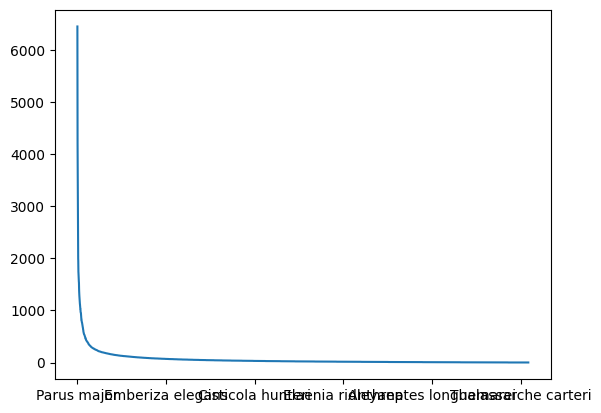

In [28]:
sci_name_counts.plot()

In [5]:
from transformers import T5Tokenizer
tokenizer = T5Tokenizer.from_pretrained("t5-base", model_max_length=512)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [31]:
for sci_name in tqdm(sci_names[sci_names.notna()]):
    ids = tokenizer.encode(sci_name)
    out = tokenizer.decode(ids)
    out = out.removesuffix(tokenizer.eos_token)
    assert sci_name == out, f"{sci_name} was not recovered and instead {sci_name} was returned"

100%|██████████| 648292/648292 [07:18<00:00, 1478.67it/s]


### Testing stratified sampling

In [86]:
from torch.utils.data import WeightedRandomSampler, Dataset, DataLoader, random_split
import pandas as pd

ds = ["a1", "a2", "a3", "a4", "a5", "a6", "b1", "c1"]
classes = pd.Series([1, 1, 1, 1, 1, 1, 2, 3])

total = classes.size
class_counts = classes.value_counts()
num_classes = class_counts.size

weights = classes.map(lambda c: 1/(class_counts[c] * num_classes))
print(weights.sum())

sampler = WeightedRandomSampler(weights=weights, num_samples=20)


0.9999999999999999


In [84]:
import torch
seed = 12345
split = lambda seq: random_split(seq,
                                 [0.5, 0.5],
                                 generator=torch.Generator().manual_seed(seed),
                                )
ds_split = split(ds)
cl_split = split(classes)
for ds, c in zip(ds_split, cl_split):
    print(list(zip(ds, c)))

[('a3', 1), ('a1', 1), ('a6', 1), ('b1', 2)]
[('a5', 1), ('a4', 1), ('a2', 1), ('c1', 3)]


In [98]:
pd.Series(cl_split[0])
subset = cl_split[0]
pd.Series(iter(subset))

0    1
1    1
2    1
3    2
dtype: int64

In [45]:
dl = DataLoader(ds, batch_size=2, sampler=sampler)

for batch in dl:
    print(batch)

['c1', 'b1']
['b1', 'c1']
['a4', 'c1']
['a3', 'b1']
['b1', 'c1']
['b1', 'b1']
['b1', 'a4']
['c1', 'c1']
['a3', 'c1']
['c1', 'c1']
